 ## 1. Import Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib.colors import Normalize

## 2. Type of ds

In [2]:
type(fashion_mnist) # fashion_mnist is a module inside tensorflow.keras.datasets

module

## 3. Load Fashion-MNIST dataset

In [3]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
#The function load_data() returns a tuple containing training and testing data

# Print the shape of data
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


In [4]:
## mnist.load_data()

### 3.1 Max Value in the entire X_train dataset

In [5]:
np.max(X_train)

255

### 3.2 Avg Value in the entire X_train Dataset

In [6]:
np.mean(X_train)

72.94035223214286

### 3.3 Labels (class names or categories) corresponding to the training dataset X_train

In [7]:
y_train # contains numbers (0–9), each representing a clothing category.

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [8]:
np.unique(y_train) # returns the sorted unique class labels present in y_train

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [9]:
class_names = [
    "t-shirt/top", "trouser", "pullover", "dress", "coat",
    "sandal", "shirt", "sneaker", "bag", "ankle boot"
]
print(class_names) 

# 0 → t-shirt/top  
# 1 → trouser  
# 2 → pullover  
# 3 → dress  
# 4 → coat  
# 5 → sandal  
# 6 → shirt  
# 7 → sneaker  
# 8 → bag  
# 9 → ankle boot  



['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']


## 4. Data Exploration|

### 4.1 Dimensions of the training dataset 

In [10]:
X_train.shape 

# 60000 → Number of training images (60,000 samples)
# 28 → Image height (28 pixels)
# 28 → Image width (28 pixels)

(60000, 28, 28)

### 4.2 Dimensions of the testing dataset 

In [11]:
X_test.shape

# 10000 → Number of test images (10,000 samples)
# 28 → Image height (28 pixels)
# 28 → Image width (28 pixels)

(10000, 28, 28)

### 4.3 Visualizing a sample image from the X_train dataset 

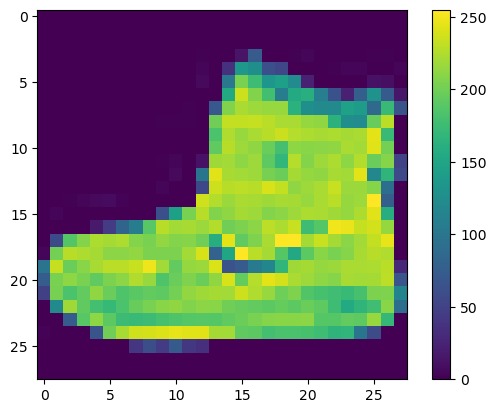

In [12]:
plt.figure() # Creates a new figure in Matplotlib
plt.imshow(X_train[0]) # Displays the second image from X_train
plt.colorbar() # Adds a color scale next to the image.

In [13]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

### 4.4 Normalize the image pixel values from [0, 255] to [0, 1]

In [14]:
 X_train = X_train/255.0

In [15]:
 X_test = X_test/255.0

In [16]:
 np.max(X_train) # Max pixel value in the dataset X_train

1.0

### 4.5 Display a sample image to see results after normalization

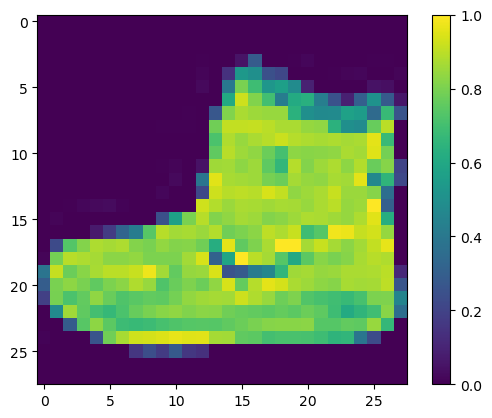

In [17]:
plt.figure()
plt.imshow(X_train[0])
plt.colorbar()

## 5 Data Augmentation

### 5.1 Reshaping 

In [18]:
# Reshape for augmentation (adding a channel dimension)
X_train = X_train.reshape(-1, 28, 28, 1)

### 5.2 Random selection

In [19]:
# Select 5 random images
random_indices = random.sample(range(X_train.shape[0]), 5)
random_images = X_train[random_indices]

### 5.3 Augmentation techniques

In [20]:
# 5 image augmentation techniques
augmentations = {
    "Rotated (30°)": ImageDataGenerator(rotation_range=30),
    "Zoomed (20%)": ImageDataGenerator(zoom_range=0.2),
    "Width Shifted (20%)": ImageDataGenerator(width_shift_range=0.2),
    "Height Shifted (20%)": ImageDataGenerator(height_shift_range=0.2),
    "Sheared (15°)": ImageDataGenerator(shear_range=15),
}


### 5.4 Visualizing each Aug Techn.

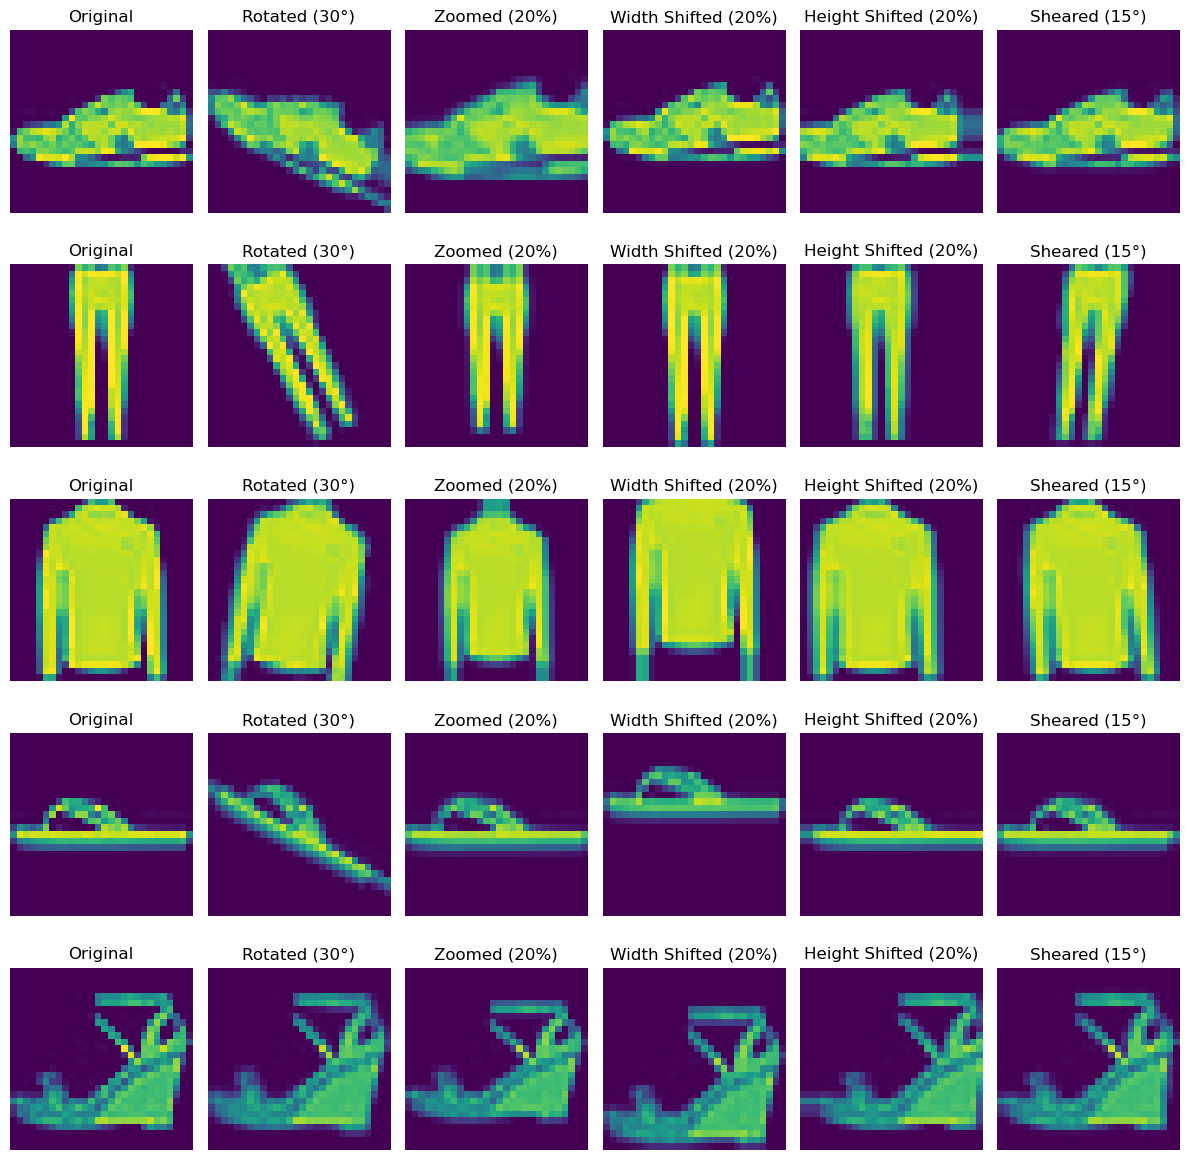

In [21]:

fig, axes = plt.subplots(len(random_images), len(augmentations) + 1, figsize=(12, 12))

# Choose a colormap - you can change this to other options like 'jet', 'plasma', 'inferno', etc.
colormap = 'viridis'

# Create a normalizer to ensure consistent color mapping across all images
# Assuming pixel values are between 0-1 for grayscale images
norm = Normalize(vmin=0, vmax=1)

for i, image in enumerate(random_images):
    # Make sure image is 2D by squeezing if needed
    image_2d = image.squeeze()
    
    # Display the original image with colormap in the first column
    axes[i, 0].imshow(image_2d, cmap=colormap, norm=norm)
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")
    
    # Apply each augmentation and display
    for j, (title, generator) in enumerate(augmentations.items()):
        # Prepare image for augmentation
        if len(image.shape) == 2:
            # Add batch and channel dimensions: (28,28) → (1,28,28,1)
            image_for_aug = np.expand_dims(np.expand_dims(image, axis=0), axis=-1)
        elif len(image.shape) == 3 and image.shape[-1] == 1:
            # Just add batch dimension: (28,28,1) → (1,28,28,1)
            image_for_aug = np.expand_dims(image, axis=0)
        else:
            # Handle other cases if needed
            image_for_aug = np.expand_dims(image, axis=0)
            
        # Generate augmented image
        augmented_image = next(generator.flow(image_for_aug, batch_size=1))[0]
        
        # Make sure augmented image is 2D
        augmented_image_2d = augmented_image.squeeze()
        
        # Display augmented image with colormap
        axes[i, j + 1].imshow(augmented_image_2d, cmap=colormap, norm=norm)
        axes[i, j + 1].set_title(title)
        axes[i, j + 1].axis("off")

plt.tight_layout()
plt.show()

## 6. Training Models

### 6.1 Model Training on Original Data  without Augmentation

In [22]:
# Reshape data to add channel dimension (for CNN)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [23]:
# Convert labels to categorical format (for categorical_crossentropy loss)
y_train_categorical = to_categorical(y_train, num_classes=10)
y_test_categorical = to_categorical(y_test, num_classes=10)

In [24]:
def create_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    return model

# Create and compile model BEFORE augmentation
model_before = create_model()
model_before.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_before.summary()

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_before = model_before.fit(
    X_train, y_train_categorical, 
    epochs=5, batch_size=64,
    validation_data=(X_test, y_test_categorical), 
  
)





C:\Users\Oseko\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,418 (880.54 KB)

 Trainable params: 225,226 (879.79 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 35ms/step - accuracy: 0.7597 - loss: 0.7130 - val_accuracy: 0.8580 - val_loss: 0.3786
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - accuracy: 0.8686 - loss: 0.3662 - val_accuracy: 0.8873 - val_loss: 0.3115
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - accuracy: 0.8854 - loss: 0.3179 - val_accuracy: 0.8748 - val_loss: 0.3315
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.8956 - loss: 0.2842 - val_accuracy: 0.9023 - val_loss: 0.2754
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - accuracy: 0.9035 - loss: 0.2633 - val_accuracy: 0.8472 - val_loss: 0.3982


### Saving original model (before aug)

In [ ]:
# Save model
model_before.save("model_before_augmentation.keras")

## 6.2  Model Training on Aug. Data 

In [ ]:
# Define data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=5, 
    zoom_range=0.1,
    width_shift_range=0.05, 
    height_shift_range=0.05, 
    horizontal_flip=True
)
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

# Create augmented data generator
train_generator = train_datagen.flow(X_train, y_train_categorical, batch_size=64)

# Create and compile model AFTER augmentation
model_after = create_model()  # Create a new instance of the model
model_after.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with augmented data
history_after = model_after.fit(
    train_generator, 
    epochs=5,
    validation_data=(X_test, y_test_categorical),
   
)





In [ ]:
# Define data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=5, 
    zoom_range=0.1,
    width_shift_range=0.05, 
    height_shift_range=0.05, 
    horizontal_flip=True
)
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

# Create augmented data generator
train_generator = train_datagen.flow(X_train, y_train_categorical, batch_size=64)

# Create and compile model AFTER augmentation
model_after = create_model()  # Create a new instance of the model
model_after.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with augmented data
history_after = model_after.fit(
    train_generator, 
    epochs=5,
    validation_data=(X_test, y_test_categorical),
   
)


### Saving Model after augmentation

In [27]:
model_after.save("model_after_augmentation.keras")

## 7. Model performance Before and After Aug

In [28]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load models
model_before = load_model("model_before_augmentation.keras", compile=False)
model_after = load_model("model_after_augmentation.keras", compile=False)


# Recompile to restore metrics
model_before.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_after.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Evaluate before augmentation
print("\n==== Model Performance BEFORE Augmentation ====")
test_loss_before, test_accuracy_before = model_before.evaluate(X_test, y_test_categorical)
print(f"Test Accuracy: {test_accuracy_before:.4f}")
print(f"Test Loss: {test_loss_before:.4f}")

y_pred_before = model_before.predict(X_test)
y_pred_classes_before = np.argmax(y_pred_before, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

print("\nConfusion Matrix (Before Augmentation):")
print(confusion_matrix(y_true, y_pred_classes_before))
print("\nClassification Report (Before Augmentation):")
print(classification_report(y_true, y_pred_classes_before))

# Evaluate after augmentation
print("\n==== Model Performance AFTER Augmentation ====")
test_loss_after, test_accuracy_after = model_after.evaluate(X_test, y_test_categorical)
print(f"Test Accuracy: {test_accuracy_after:.4f}")
print(f"Test Loss: {test_loss_after:.4f}")

y_pred_after = model_after.predict(X_test)
y_pred_classes_after = np.argmax(y_pred_after, axis=1)

print("\nConfusion Matrix (After Augmentation):")
print(confusion_matrix(y_true, y_pred_classes_after))
print("\nClassification Report (After Augmentation):")
print(classification_report(y_true, y_pred_classes_after))



==== Model Performance BEFORE Augmentation ====
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8431 - loss: 0.4088
Test Accuracy: 0.8472
Test Loss: 0.3982
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Confusion Matrix (Before Augmentation):
[[527   1   4  47  10   0 406   0   5   0]
 [  1 975   0  17   2   0   3   0   2   0]
 [  9   0 499   9 296   0 186   0   1   0]
 [  2   4   2 911  33   0  44   0   4   0]
 [  0   1   4  29 890   0  73   0   3   0]
 [  0   0   0   1   0 991   0   4   0   4]
 [ 20   0  21  32  97   0 819   0  11   0]
 [  0   0   0   0   0  48   0 939   1  12]
 [  0   1   1   3   6   1  13   1 974   0]
 [  0   0   0   0   0  11   0  41   1 947]]

Classification Report (Before Augmentation):
              precision    recall  f1-score   support

           0       0.94      0.53      0.68      1000
           1       0.99      0.97      0.98      1000
           2       0.94      0.50      0.65      1000
           3       0.87      0.91      0.89      1000
      

### 7.1 Comparing the performance of the two models

ValueError: x and y must have same first dimension, but have shapes (5,) and (50,)

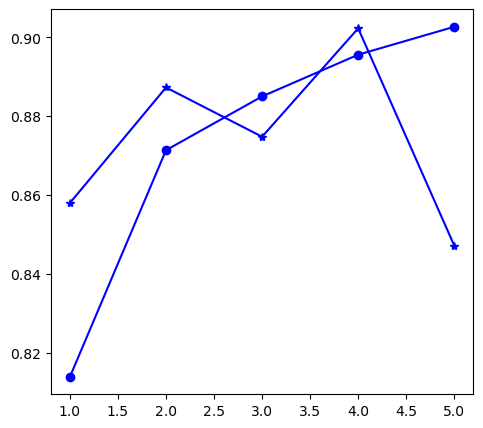

In [29]:


# Extract accuracy and loss for BEFORE augmentation
train_acc_before = history_before.history['accuracy']
val_acc_before = history_before.history['val_accuracy']
train_loss_before = history_before.history['loss']
val_loss_before = history_before.history['val_loss']

# Extract accuracy and loss for AFTER augmentation
train_acc_after = history_after.history['accuracy']
val_acc_after = history_after.history['val_accuracy']
train_loss_after = history_after.history['loss']
val_loss_after = history_after.history['val_loss']

epochs = range(1, len(train_acc_before) + 1)

plt.figure(figsize=(12, 5))

# Plot Accuracy Comparison
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_before, 'bo-', label='Train Acc (Before)')
plt.plot(epochs, val_acc_before, 'b*-', label='Val Acc (Before)')
plt.plot(epochs, train_acc_after, 'ro-', label='Train Acc (After)')
plt.plot(epochs, val_acc_after, 'r*-', label='Val Acc (After)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Plot Loss Comparison
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_before, 'bo-', label='Train Loss (Before)')
plt.plot(epochs, val_loss_before, 'b*-', label='Val Loss (Before)')
plt.plot(epochs, train_loss_after, 'ro-', label='Train Loss (After)')
plt.plot(epochs, val_loss_after, 'r*-', label='Val Loss (After)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


### 7.2 Another Graph variation incase you dont understand the first one 

In [ ]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss curves
def plot_training_curves(history, title):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label="Train Accuracy", linestyle='--', marker='o')
    plt.plot(history.history['val_accuracy'], label="Validation Accuracy", linestyle='-', marker='s')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.legend()
    plt.grid()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label="Train Loss", linestyle='--', marker='o')
    plt.plot(history.history['val_loss'], label="Validation Loss", linestyle='-', marker='s')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title} - Loss")
    plt.legend()
    plt.grid()

    plt.show()

# If history objects are available:
plot_training_curves(history_before, "Model Before Augmentation")
plot_training_curves(history_after, "Model After Augmentation")
